In [1]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable

from utility_functions.utils import * #read_data, read_press, getnearpos, folder_files, headspace
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
rc['font.family'] = 'sans-serif'
rc['font.sans-serif'] = ['Verdana']

In [2]:
def plot_cycle(disch, chrg, press, channel, style=None, n=None, leg=''):
    color= 'xkcd:ocean blue'
    if n==None:
        n=2
#     color='#045a8d'
#     color='xkcd:cerulean'
    #find currents for charge and discharge and //normalize by area
    disc_i= np.mean(disch['I/mA']) #/(np.pi*0.6**2)
    chrg_i= np.mean(chrg['I/mA']) #/(np.pi*0.6**2)
    print('discharge current (mA): ' +str(disc_i))
    #find the final capacity reached on discharge in mAh
    cap=disch['Capacity/mA.h'].iloc[-1]
    if style ==None:
        style = 'solid'
        
    x1=disch['Capacity/mA.h'] #/(np.pi*0.6**2)
    y1=disch['Ewe/V']
    
    x2=(cap-chrg['Capacity/mA.h']) #/(np.pi*0.6**2)
    y2=chrg['Ewe/V']
    
    #fig, (ax, ax3)= plt.subplots(2, sharex=True, figsize= (9,10)) 
    #fig, ax= plt.subplots( figsize=(8.275,5))
    fig, ax= plt.subplots( figsize=(7,5))
    ax2 = ax.twinx()
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)
    
    ax.plot(x1, y1, c=color, linestyle=style, label=leg, linewidth=2)
    if (str(disch) != str(chrg)):
        ax.plot(x2, y2, c=color, linestyle=style, label='', linewidth=2)
    #ax.plot([0.01,cap],[2.27,2.27], c='k', linestyle=(0,(1,5)), linewidth=2)
    
    st1=disch['time/s'].iloc[0]
    end1=disch['time/s'].iloc[-1]
    
    st2=chrg['time/s'].iloc[0]
    end2=chrg['time/s'].iloc[-1]
    
    #determine start and end indices in pressure df for discharge and charge
    st_p1 = getnearpos(press['time/s'],st1)
    end_p1 = getnearpos(press['time/s'],end1)
    
    
    st_p2 = getnearpos(press['time/s'],st2)
    end_p2 = getnearpos(press['time/s'],end2)
    
    temp = press['temperature/C']+273
    umoles = press['pressure/torr']/760*headspace(channel)/temp/0.082057
    umoles = umoles-umoles.iloc[st_p1]
    elec_oxy= x1.iloc[-1]*3.6/96485/umoles[end_p1]
    
    x=[0,cap] #/(np.pi*0.6**2)]
    y=[0,-cap*3.6/n/96485*10**6]
    
    disch_cap=(press['time/s']-press['time/s'].iloc[st_p1])*-disc_i/3600
    char_cap=cap -(press['time/s']-press['time/s'].iloc[st_p2])*chrg_i/3600 #divide cap by/(np.pi*.6**2)

    gap= umoles[end_p1-1]-umoles[st_p2]
    print((disch_cap.iloc[-1]*3.6/96485/(umoles[end_p1]*10**(-6))))
    line1, = ax2.plot(x, y, 'k-' , label= str(n)+' e$^-$/O$_2$',linewidth= 2, linestyle = '--')
    
    ax2.plot(disch_cap[st_p1:end_p1], (umoles)[st_p1:end_p1], 'o', color='#001933', label='discharge', linewidth=3, markevery=(0.0,0.02))# (0,(6,6))) # color '#9E0003' '#ec7014'
    if (str(disch) != str(chrg)):
        ax2.plot(char_cap[st_p2:end_p2+1], (umoles)[st_p2:end_p2+1]+gap, 'o', mfc='white', color='#001933', label='charge', linewidth=3, markevery=(0.0,0.02))# (0,(6,6)))
    
    
    #slope_c, int_c = np.polyfit(char_cap[st_p2:end_p2], umoles[st_p2:end_p2], 1)
    #epermol_c = 1/(slope_c/3.6*96485/10**6)
    #slope_dis, int_dis = np.polyfit(disch_cap[st_p1:end_p1], umoles[st_p1:end_p1], 1)
    #epermol_d = -1/(slope_dis/3.6*96485/10**6)
    
    ax2.legend(fontsize=14, loc = 'upper right')
    ax.set_ylabel('Voltage (V vs. Zn/Zn$^{2+}$)', color=color, fontsize=20)
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax2.set_ylabel('n$_{gas}$ ($\mu$mol)', fontsize=20)
    plt.tight_layout()
    #ax.set_ylim([0,3.5])
    print("o2 consumed: "+ str(umoles[st_p1]-(umoles[end_p1] )))
    print("o2 evolved: "+ str(umoles[end_p2]-(umoles[st_p2+1] )))
    print((umoles[end_p2]-(umoles[st_p2+1]))/(umoles[st_p1]-(umoles[end_p1])))

    epermol_c = cap * 3.6 / 96485 *10**6 / (umoles[end_p2-1]-(umoles[st_p2+1]))
    epermol_d = cap * 3.6 / 96485 *10**6 / (umoles[st_p1]-(umoles[end_p1]))
    
    print('e per mol on discharge = ' + str(epermol_d))
    #print('e per mol on charge = ' + str(epermol_c))
    
    return 

In [34]:
def plot_CA_cycles(discharge, cp1, ca, press, ch, cyclenum=1, leg=None, offset=0, n=2):
    
    i_dis = -1*np.mean( discharge['I/mA'] ) #calculate discharge and charge current (mA)
    i_ch = np.mean(cp1['I/mA'])
    ca['Capacity/mA.h'] = ca['Capacity/mA.h'] + cp1['Capacity/mA.h'].iloc[-1]   
    umoles = press['pressure/torr']/760*headspace(ch)/(press['temperature/C']+273)/0.082057
    umoles = umoles-umoles.iloc[0]
    col = ['#003366', '#0066CC', '#3399FF', '#99CCFF']
    
    cap = []
    curr = []
    files_ec = pd.concat([discharge, cp1, ca], sort=True) 
    
    for i in range(len(umoles)):
        dex = getnearpos( files_ec['time/s'], press['time/s'].iloc[i] )
        cap.append( files_ec['Capacity/mA.h'].iloc[dex] )
        curr.append( files_ec['I/mA'].iloc[dex] )

    umolesdf = pd.DataFrame( press['time/s'], columns=['time/s'] )
    umolesdf['umoles'] = umoles
    umolesdf['Capacity/mA.h'] = cap
    umolesdf['I/mA'] = curr
    
    st1= discharge['time/s'].iloc[0]
    end1= discharge['time/s'].iloc[-1]
    st2=cp1['time/s'].iloc[0]
    end2=cp1['time/s'].iloc[-1]
    st3=ca['time/s'].iloc[0]
    end3=ca['time/s'].iloc[-1]
    end_cap = [discharge['Capacity/mA.h'].iloc[-1], cp1['Capacity/mA.h'].iloc[-1], ca['Capacity/mA.h'].iloc[-1]]
    
    fig, (ax, ax2)= plt.subplots(2, sharex=True, figsize= (7,10)) 
    ax.plot((discharge['Capacity/mA.h']), discharge['Ewe/V'], c=col[cyclenum-1], linestyle='-', linewidth=2.5, label = cyclenum )
    ax.plot([end_cap[0], end_cap[0]-cp1['Capacity/mA.h'].iloc[5] ], [discharge['Ewe/V'].iloc[-1], cp1['Ewe/V'].iloc[5] ], c=col[cyclenum-1], linestyle='-', linewidth=2.5, label='')
    ax.plot(end_cap[0]-cp1['Capacity/mA.h'], cp1['Ewe/V'], color=col[cyclenum-1], label='', linewidth=2.5)
    ax.plot(end_cap[0]- ca['Capacity/mA.h'], ca['Ewe/V'], color= col[cyclenum-1], linewidth=2.5, label='') 
    ax.plot([0.01, 1.0],[2.27,2.27], c='grey', linestyle=(0,(1,5)), linewidth=2, label='')
    

    st_p1 = getnearpos(press['time/s'],st1) #find time at beginning of discharge
    end_p1 = getnearpos(press['time/s'],end1) #find time at end of discharge
    
    st_p2 = getnearpos(press['time/s'],st2)
    end_p2 = getnearpos(press['time/s'],end2)
    
    st_p3 = getnearpos(press['time/s'],st3)
    end_p3 = getnearpos(press['time/s'],end3)
    
    umolesdf['umoles'] = umolesdf['umoles']-umolesdf['umoles'].iloc[st_p1]
    
    x=[0, end_cap[0]]
    y=[0+offset,-end_cap[0]*3.6/n/96485*10**6+offset]
    
    print('total moles of gas consumed: ' + str(-umoles.iloc[end_p1]+umoles.iloc[st_p1]))
    print('total moles of gas evolved: ' + str(umoles.iloc[end_p3-5]-umoles.iloc[st_p2]))
    oerorr=(umoles.iloc[end_p3]-umoles.iloc[st_p2])/(-umoles.iloc[end_p1]+umoles.iloc[st_p1])
    
    print('charge cap= ' + str( ca['Capacity/mA.h'].iloc[-1] ) )
    print('oer/orr: '+ str(oerorr))
    print('final current= ' + str(ca['I/mA'].iloc[-1]))
    print('charge time (h) : ' + str((ca['time/s'].iloc[-1]- cp1['time/s'].iloc[0])/3600))


    pressure_gap=umoles.iloc[end_p1]-umoles.iloc[st_p2]
    
    ax2.plot(umolesdf['Capacity/mA.h'][st_p1:end_p1+1], umolesdf['umoles'][st_p1:end_p1+1]+offset,  'o-', color= col[cyclenum-1], linewidth=1.5, markersize=6, label='')#, markevery=(0.0,0.02))
    ax2.plot(end_cap[0]-umolesdf['Capacity/mA.h'][st_p2:end_p3-1], (umolesdf['umoles'])[st_p2:end_p3-1]+pressure_gap+offset,  'o-', color=col[cyclenum-1], linewidth=1.5, markersize=6, mfc='white', markevery=(0.0,0.012), label='')
    ax2.plot(x,y, 'k-',  c='#606060', linestyle='--', label= '',linewidth= 1)
    
    ax.set_ylabel('Voltage (V vs. Zn/Zn$^{2+}$)', fontsize=24)
    ax2.set_ylabel('$\Delta$ n$_{gas}$ ($\mu$mol)', fontsize=24)
    ax2.set_xlabel('Capacity (mAh)', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    #ax.set_ylim([1.5,5])
    ax.set_xlim([-0.04,1.04])
    plt.tight_layout()
    return ( umolesdf['umoles'][end_p3-1]+pressure_gap )



discharge current (mA): -0.5000638509399478
-6.2752515369672714
o2 consumed: 13.343473676687722
o2 evolved: 6.565420365132894
0.49203232413185544
e per mol on discharge = 2.796644650064439
discharge current (mA): -0.5000620535215053
-5.670356516781582
o2 consumed: 16.684262768584617
o2 evolved: 11.16288532623038
0.6690667415793384
e per mol on discharge = 2.236629507885942


(970.0, 1000.0)

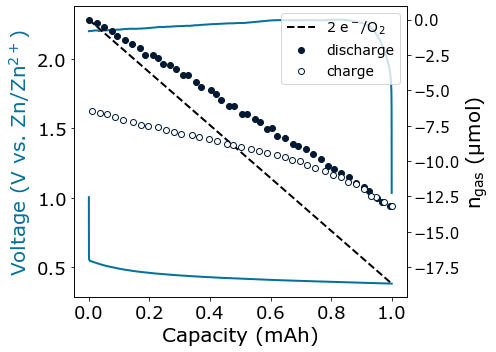

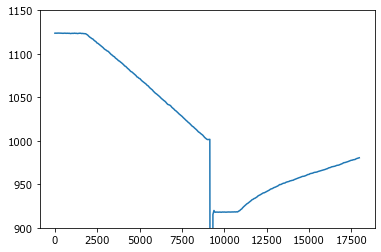

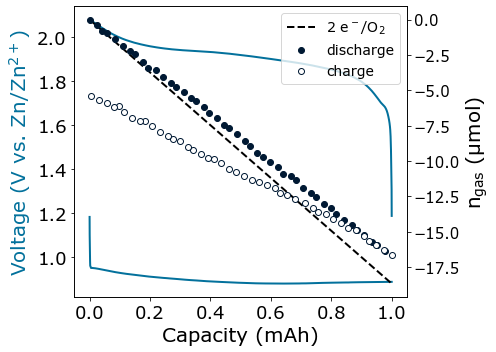

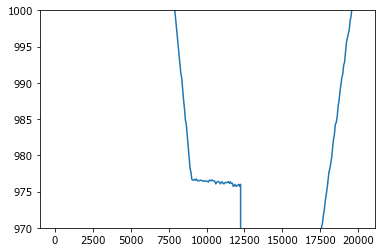

In [6]:

zno2_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210528_Zn_O2_test_ZnOTf_H2O/210528_Zn_O2_test_ZnOTf_H2O_Ch4__2021-05-28_14.05_20.txt')
zno2_cycle = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210528_Zn_O2_test_ZnOTf_H2O/')
plot_cycle(zno2_cycle[1], zno2_cycle[3], zno2_p, 4, n=2)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210528_Zn_O2_test_ZnOTf_H2O/210528_Zn_O2_cycle.png', transparent = True, dpi=600, bbox_inches='tight')
plt.figure()
plt.plot(zno2_p['time/s'], zno2_p['pressure/torr'])
plt.ylim(900,1150)



znxc72p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210603_Zn_O2_XC72_ZnOTf2_cycle/210603_Zn_O2_XC72_ZnOTf2_cycle_Ch4__2021-06-03_12.17_29.txt')
znxc72 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210603_Zn_O2_XC72_ZnOTf2_cycle/')
plot_cycle(znxc72[1], znxc72[3], znxc72p, 4, n=2)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210603_Zn_O2_XC72_ZnOTf2_cycle/210603_Zn_O2_XC72_ZnOTf2_cycle.png', transparent = True, dpi=600, bbox_inches='tight')

plt.figure()
plt.plot(znxc72p['time/s'], znxc72p['pressure/torr'])
plt.ylim(970,1000)


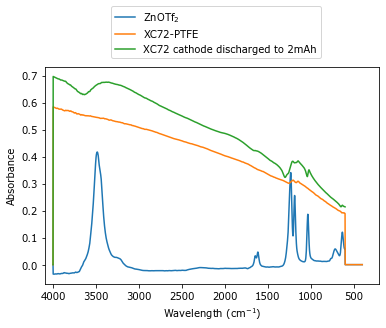

In [4]:
#ftir

control_xc72_ptfe= pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/FTIR/210824_FTIR_ZnO2_Cathode/210824_xc72-ptfe-powder-pristine.CSV', names = ['wavelength', 'absorbance'])

control_ZnOtf2 = pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/FTIR/210824_FTIR_ZnO2_Cathode/210824_ZnOTf2_powder.CSV', names = ['wavelength', 'absorbance'])

sample_zn_air_cathode = pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/FTIR/210824_FTIR_ZnO2_Cathode/210824_2mAhdischarge_znO2_xc72-powder.CSV', names = ['wavelength', 'absorbance'])


fig,ax = plt.subplots()
ax.plot(control_ZnOtf2['wavelength'], control_ZnOtf2['absorbance'], label = 'ZnOTf$_2$')
ax.plot(control_xc72_ptfe['wavelength'], control_xc72_ptfe['absorbance'], label ='XC72-PTFE')

ax.plot(sample_zn_air_cathode['wavelength'], sample_zn_air_cathode['absorbance'], label = 'XC72 cathode discharged to 2mAh')



ax.set_xlim(4100, 200)
ax.set_xlabel('Wavelength (cm$^{-1}$)')
ax.set_ylabel('Absorbance')
plt.legend(bbox_to_anchor = (0.84,1.3))
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/FTIR/210824_FTIR_ZnO2_Cathode/210824_comparison.png', transparent = True, dpi=600, bbox_inches='tight')



discharge current (mA): -0.5000274026086956
-5.926905815274628
o2 consumed: 2.2259212153121126
o2 evolved: -2.2303224645263526
-1.0019772708863026
e per mol on discharge = 5.987010022621749
discharge current (mA): -0.5000770534417345
-5.265415242939973
o2 consumed: 9.266740409055515
o2 evolved: -9.26492070868423
-0.9998036310190035
e per mol on discharge = 4.0271059365620205


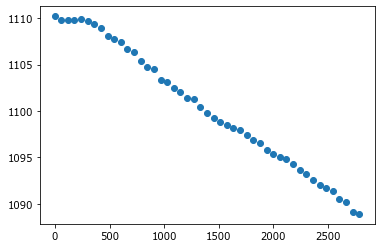

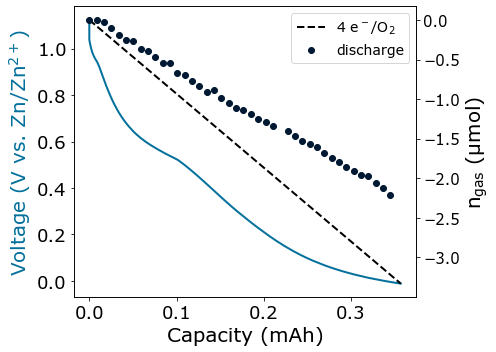

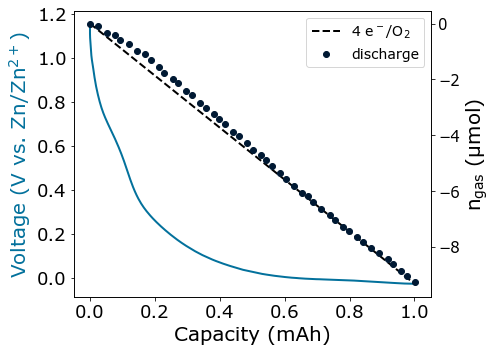

In [5]:

newformula_xc72p50 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210823_Zn_XC72onP50cathode_500uA/210823_Zn_XC72onP50cathode_500uA_2_Ch4__2021-08-23_14.17_28.txt')
newform_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210823_Zn_XC72onP50cathode_500uA/')

plt.figure()
plt.plot(newformula_xc72p50['time/s'], newformula_xc72p50['pressure/torr'], 'o')

plot_cycle(newform_ec[1], newform_ec[1], newformula_xc72p50, 4, n=4)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210823_Zn_XC72onP50cathode_500uA/210823_Zn_XC72onP50.png', transparent = True, dpi=600, bbox_inches='tight')


newformula_xc72mesh = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210826_Zn_newXC72onmeshcathode_500uA/210826_Zn_newXC72onmeshcathode_500uA_Ch4__2021-08-26_12.39_00.txt')
mesh_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210826_Zn_newXC72onmeshcathode_500uA/')

plot_cycle(mesh_ec[1], mesh_ec[1], newformula_xc72mesh, 4, n=4)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210826_Zn_newXC72onmeshcathode_500uA/210826_Zn_newXC72onmeshcathode.png', transparent = True, dpi=600, bbox_inches='tight')

discharge current (mA): -0.5000173189373298
-3.052904890566949
o2 consumed: 34.65647043036263
o2 evolved: -34.447097475822915
-0.9939586186377397
e per mol on discharge = 2.1533241295743037


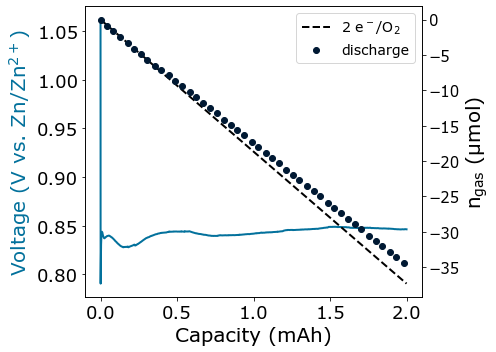

In [6]:
#ftir cell

ftirdischarge = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210823_Zn_O2_2mAh_500uA_ftirsample/210823_Zn_O2_2mAh_500uA_ftirsample_Ch4__2021-08-23_15.33_30.txt')
ftirdischarge_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210823_Zn_O2_2mAh_500uA_ftirsample/')

plot_cycle(ftirdischarge_ec[1], ftirdischarge_ec[1], ftirdischarge, 4, n=2)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210823_Zn_O2_2mAh_500uA_ftirsample/210823_Zn_discharge_ftir.png', transparent = True, dpi=600, bbox_inches='tight')



4.158668518066406
5.61132589975993


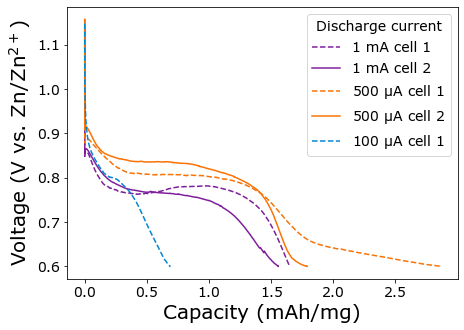

In [25]:
#Zn LONG Discharge Study

long_100_1 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210818_Zn_O2_100uA_longdisch1/')
long_100_2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210826_Zn_O2_100uA_longdisch2/')
long_100_3 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211029_Zn_O2_longdisch_100uA/')

long_500_1 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210818_Zn_O2_500uA_longdisch1/')
long_500_2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210827_Zn_O2_500uA_longdisch2/')
long_500_3 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211029_Zn_O2_longdisch_500uA/')

long_1mA_1 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210820_Zn_O2_1mA_longdisch1/')
long_1mA_2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210830_Zn_O2_1mA_longdisch2/')

cathode_mass= [2.25, 1.95, 1.35, 2.325, 1.575, 2.175, 2.325, 1.35]

fig, ax= plt.subplots( figsize=(7,5))

ax.plot(long_1mA_1[1]['Capacity/mA.h']/cathode_mass[0], long_1mA_1[1]['Ewe/V'], '--', label = '1 mA cell 1', color = 'xkcd:purple')
ax.plot(long_1mA_2[1]['Capacity/mA.h']/cathode_mass[1], long_1mA_2[1]['Ewe/V'], label = '1 mA cell 2', color = 'xkcd:purple')


ax.plot(long_500_1[1]['Capacity/mA.h']/cathode_mass[2], long_500_1[1]['Ewe/V'], '--', label = '500 $\mu$A cell 1', color = 'xkcd:orange')
ax.plot(long_500_2[1]['Capacity/mA.h']/cathode_mass[3], long_500_2[1]['Ewe/V'], label = '500 $\mu$A cell 2', color = 'xkcd:orange')
#ax.plot(long_500_3[1]['Capacity/mA.h']/cathode_mass[4], long_500_3[1]['Ewe/V'], 'o', label = '500 $\mu$A cell 3', color = 'xkcd:orange')



ax.plot(long_100_1[1]['Capacity/mA.h']/cathode_mass[5], long_100_1[1]['Ewe/V'], '--', label = '100 $\mu$A cell 1', color = 'xkcd:cerulean')
#ax.plot(long_100_2[1]['Capacity/mA.h']/cathode_mass[6], long_100_2[1]['Ewe/V'], label = '100 $\mu$A cell 2', color = 'xkcd:cerulean')
#ax.plot(long_100_3[1]['Capacity/mA.h']/cathode_mass[7], long_100_3[1]['Ewe/V'], 'o', label = '100 $\mu$A cell 2', color = 'xkcd:cerulean')



ax.set_ylabel('Voltage (V vs. Zn/Zn$^{2+}$)', fontsize=20)
ax.set_xlabel('Capacity (mAh/mg)', fontsize=20)
leg = ax.legend(fontsize=14, bbox_to_anchor=(1,1))
leg.set_title('Discharge current',prop={'size':14})
ax.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/Zn_longdischarge_plot/Zn_longdischarge_plot.png', transparent = True, dpi=600, bbox_inches='tight')


print(long_500_2[1]['Capacity/mA.h'].iloc[-1])

print(long_500_3[1]['Capacity/mA.h'].iloc[-1])

discharge current (mA): -0.5000994558288769
The 20th value of this array is: 1203.96
The 139th value of this array is: 8411.699999999999
The 20th value of this array is: 1203.96
The 139th value of this array is: 8411.699999999999
-2.9450027323622194
o2 consumed: 16.953165361310553
o2 evolved: -16.823191231622815
-0.9923333414782612
e per mol on discharge = 2.2013365765156547


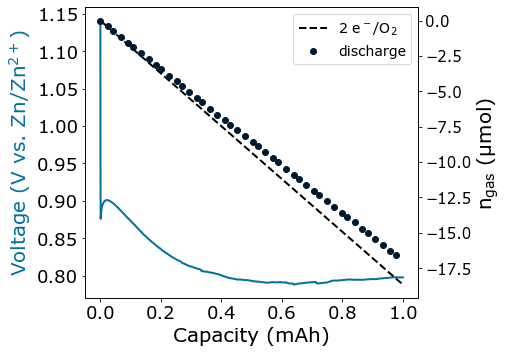

In [12]:
tims_discharge = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210830_Zn_O2_XC72_discharge_1mAh_TIMS/')
tims_disch_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210830_Zn_O2_XC72_discharge_1mAh_TIMS/210830_Zn_O2_XC72_discharge_1mAh_TIMS_Ch4__2021-08-30_14.08_19.txt')

plot_cycle(tims_discharge[1], tims_discharge[1], tims_disch_p, 4, n=2)



discharge current (mA): -0.50004822004662
The 20th value of this array is: 1206.6000000000001
The 139th value of this array is: 8407.14
The 20th value of this array is: 1206.6000000000001
The 139th value of this array is: 8407.14
-136.2688109399725
o2 consumed: 1.368396481999369
o2 evolved: -1.3475734856176018
-0.9847829217221148
e per mol on discharge = 27.26967233741552
discharge current (mA): -0.5001117576206583
The 20th value of this array is: 1203.0
The 139th value of this array is: 8387.52
The 20th value of this array is: 1203.0
The 139th value of this array is: 8387.52
1321.8545965317157
o2 consumed: -0.1411075183633841
o2 evolved: 0.18509668120937306
-1.311742161978264
e per mol on discharge = -264.4779739451723


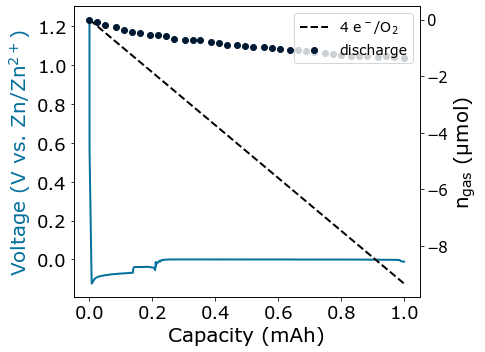

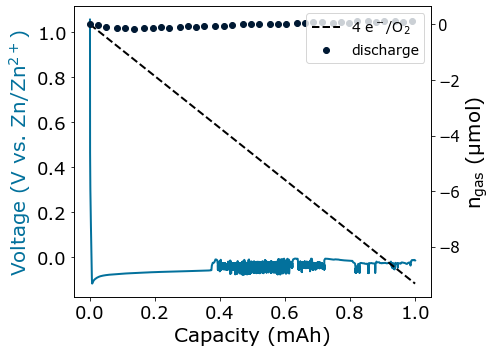

In [21]:
meshcontrol_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210902_Zn_O2_ssmesh_control_discharge/210902_Zn_O2_ssmesh_control_discharge_Ch4__2021-09-02_13.08_23.txt')
meshcontrol = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210902_Zn_O2_ssmesh_control_discharge/')

plot_cycle(meshcontrol[1], meshcontrol[1], meshcontrol_p, 4, n=4)

ssmeshcontrol2_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210907_Zn_O2_ssmesh_control_discharge_rpt/210902_Zn_O2_ssmesh_control_repeat_Ch4__2021-09-07_17.46_42.txt')
ssmeshcontrol2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210907_Zn_O2_ssmesh_control_discharge_rpt/')

plot_cycle(ssmeshcontrol2[1], ssmeshcontrol2[1], ssmeshcontrol2_p, 4, n=4)



discharge current (mA): -0.5000678038377888
The 20th value of this array is: 1204.8600000000001
The 745th value of this array is: 45100.8
The 20th value of this array is: 1204.8600000000001
The 745th value of this array is: 45100.8
89.245283288271
o2 consumed: -3.393170893078292
o2 evolved: 3.2506515352496876
-0.9579981786006333
e per mol on discharge = -67.01926208916149


6.094845136006672

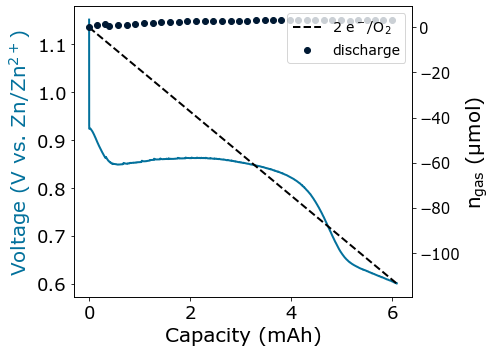

In [17]:
solubility_disc_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210907_Zn_O2_solubility_limit_peroxideinelyte/210907_Zn_O2_solubility_limit_peroxideinelyte_Ch1__2021-09-07_17.35_40.txt')
solubility_disc = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210907_Zn_O2_solubility_limit_peroxideinelyte/')

plot_cycle(solubility_disc[1], solubility_disc[1], solubility_disc_p, 1, n=2)

solubility_disc[1]['Capacity/mA.h'].iloc[-1]


discharge current (mA): -0.5001070743315508
The 30th value of this array is: 1815.18
The 149th value of this array is: 9029.039999999999
The 30th value of this array is: 1815.18
The 149th value of this array is: 9029.039999999999
-67.38960948561113
o2 consumed: 1.1053773037539685
o2 evolved: -1.025676757548581
-0.9278974283851164
e per mol on discharge = 33.76230446912591


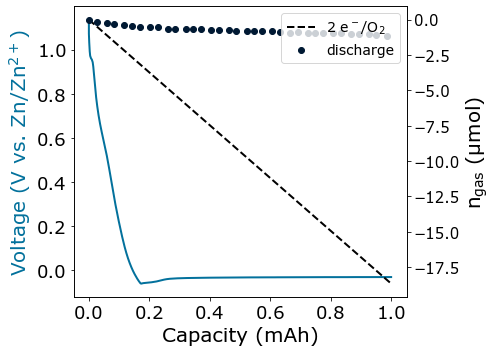

In [23]:
newp50testp = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210913_Zn_O2_newXC72onP50_test/210913_Zn_O2_newXC72onP50_test_Ch4__2021-09-13_15.00_33.txt')
newp50test = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210913_Zn_O2_newXC72onP50_test/')
plot_cycle(newp50test[1], newp50test[1], newp50testp, 4, n=2)



discharge current (mA): -0.5000541858196721
-14.004874612406292
o2 consumed: 5.307220935152955
o2 evolved: -5.303256732868405
-0.9992530549730289
e per mol on discharge = 7.031204575853189


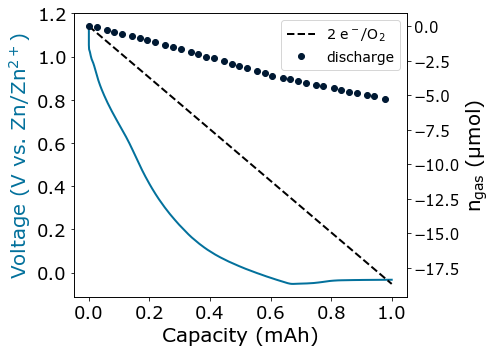

In [11]:
freestanding = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210919_Zn_O2_freestandingXC72electrodes_discharge/210919_Zn_O2_freestandingXC72electrodes_discharge_Ch4__2021-09-19_15.24_17.txt')
free_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210919_Zn_O2_freestandingXC72electrodes_discharge/')

plot_cycle(free_ec[1], free_ec[1], freestanding, 4, n=2)



discharge current (mA): -0.4998122584189723
-2.234922229809289
o2 consumed: 22.357716361494028
o2 evolved: -22.161602222645584
-0.9912283465950841
e per mol on discharge = 1.668246596650097


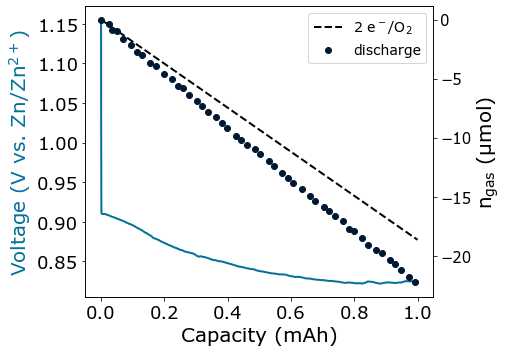

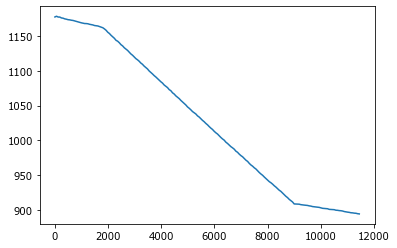

In [9]:
isotopic_dems_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210916_Zn_O2_18O2_disch_charge_dems/210916_Zn_O2_18O2_discharge_charge_dems_Ch1__2021-09-16_11.39_05.txt')
isotopic_dems = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210916_Zn_O2_18O2_disch_charge_dems/')
plot_cycle(isotopic_dems[4], isotopic_dems[4], isotopic_dems_p, 'dems1', n=2)


plt.figure()
plt.plot(isotopic_dems_p['time/s'], isotopic_dems_p['pressure/torr'])

total moles of gas consumed: 16.32331744380268
total moles of gas evolved: 10.071476216723113
charge cap= 1.0145748158295949
oer/orr: 0.617813879554783
final current= 0.015779026
charge time (h) : 9.42420488140857


-6.217375877182377

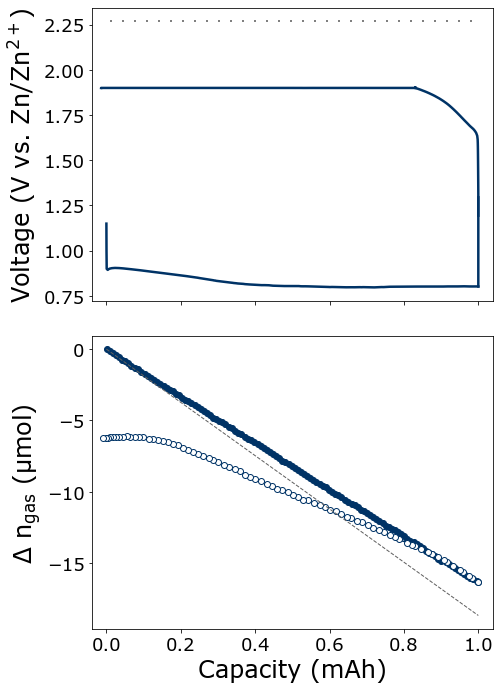

In [7]:
zn_cccv_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210923_Zn_O2_CCCVcharge_1-9Vhold/210923_Zn_O2_CCCVcharging_1-9Vhold_Ch4__2021-09-23_12.13_27.txt')
zn_cccv = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210923_Zn_O2_CCCVcharge_1-9Vhold/')
plot_CA_cycles(zn_cccv[1],zn_cccv[3],zn_cccv[4], zn_cccv_p, 4 )

discharge current (mA): -0.5001412896316507
-9.289841189124228
o2 consumed: 36.11702551347233
o2 evolved: -35.82601319514943
-0.9919425170211111
e per mol on discharge = 2.0667437794127586
discharge current (mA): -0.4998533019066937
-1.9825636284460808
o2 consumed: 38.3816477807693
o2 evolved: -38.18670102068539
-0.9949208340090707
e per mol on discharge = 1.943695207036761


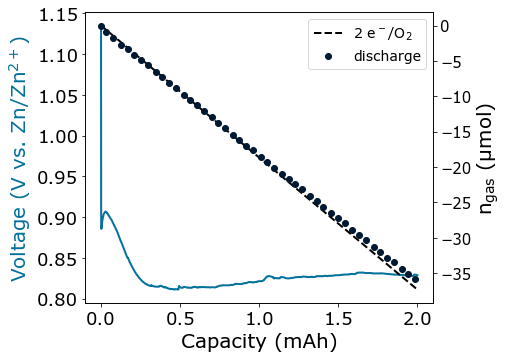

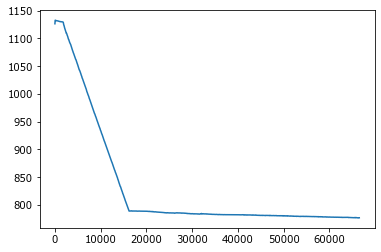

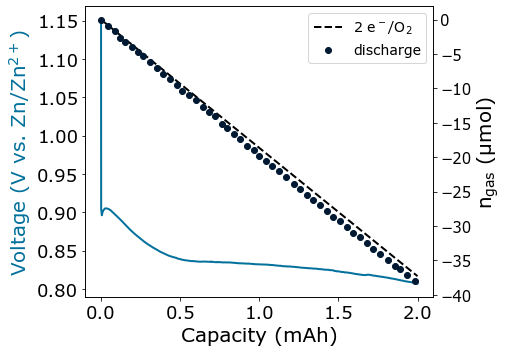

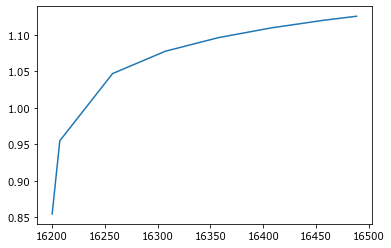

In [18]:
dems_longrest_p =  read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210908_Zn_O2_dischargefordems_overnightrest/210908_Zn_O2_dischargefordems_overnightrest_Ch4__2021-09-08_14.00_37.txt')
dems_longrest = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210908_Zn_O2_dischargefordems_overnightrest/')
plot_cycle(dems_longrest[1], dems_longrest[1], dems_longrest_p, 4, n=2)


plt.figure()
plt.plot(dems_longrest_p['time/s'], dems_longrest_p['pressure/torr'])


dems_norest_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210913_Zn_O2_norest_postdischarge_dems_2/210913_Zn_O2_norest_postdischarge_disch_2_Ch1__2021-09-13_12.04_34.txt')
dems_norest = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210913_Zn_O2_norest_postdischarge_dems_2/')
plot_cycle(dems_norest[4], dems_norest[4], dems_norest_p, 'dems1', n=2)

plt.figure()
plt.plot(dems_norest[5]['time/s'], dems_norest[5]['Ewe/V'])

discharge current (mA): -0.5000325234840426
-9.178464758739034
o2 consumed: 11.580465601906852
o2 evolved: 0.11136272105515843
0.009616428637966105
e per mol on discharge = 3.2222186388134695
discharge current (mA): -0.5000380535094339
-62.02642289843161
o2 consumed: 8.072877045134192
o2 evolved: -8.021219835132428
-0.9936011400008997
e per mol on discharge = 4.622312496506119


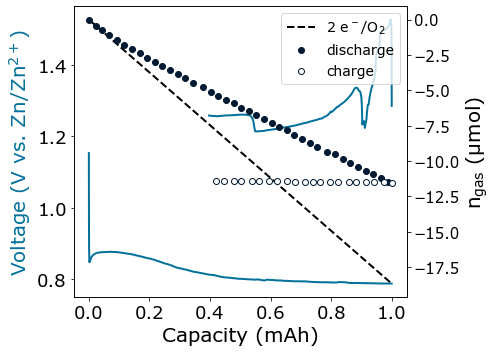

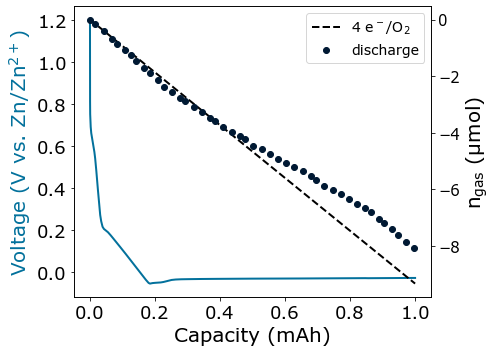

In [23]:
ag_cat_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211006_Zn_O2_AgXC72_cycle/211006_Zn_O2_AgXC72_cycle_p_Ch4__2021-10-06_13.08_49.txt')
ag_cat_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211006_Zn_O2_AgXC72_cycle/')

plot_cycle(ag_cat_ec[1],ag_cat_ec[3], ag_cat_p, 4)


p50_zn_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211006_Zn_O2_P50_cycle/211006_Zn_O2_P50_cycle_Ch3__2021-10-06_13.08_13.txt')
p50_zn_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211006_Zn_O2_P50_cycle/')


plot_cycle(p50_zn_ec[1], p50_zn_ec[1], p50_zn_p, 3, n=4)

discharge current (mA): -0.5000131912048192
-6.828541949991415
o2 consumed: 16.388805064172743
o2 evolved: 11.173434301274156
0.6817723597005977
e per mol on discharge = 2.276756857073108


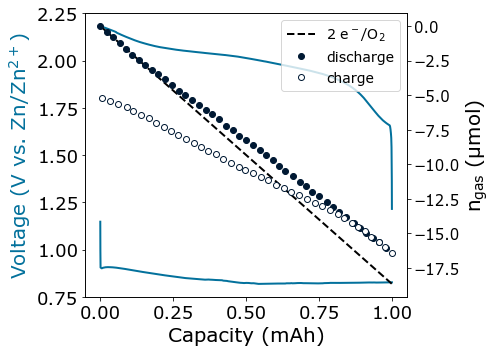

In [7]:
basic_elyte_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211008_Zn_OTf-NaOHelyte_cycle/211008_Zn_OTf-NaOHelyte_test_Ch4__2021-10-08_14.45_54.txt')
basic_elyte_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211008_Zn_OTf-NaOHelyte_cycle/')

plot_cycle(basic_elyte_ec[1], basic_elyte_ec[3], basic_elyte_p, 4, n=2)

1.0929823
20.323999999999998
1.0894098
19.808


(-1.0, 9.0)

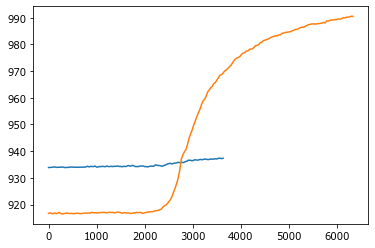

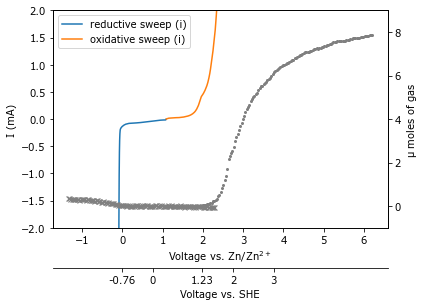

In [9]:
reductive_sweep = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211203_Zn_OTf_H2O_solventstability_reductiveLSV_Ar/')
oxidative_sweep = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211007_Zn_O2_OTfinH2O_solventstability_Ar_oxidativeLSV/')
oxidative_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211007_Zn_O2_OTfinH2O_solventstability_Ar_oxidativeLSV/211007_Zn_O2_OTfinH2O_solventstability_Ar_oxidativeLSV_Ch4__2021-10-07_14.09_07.txt')
reductive_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211203_Zn_OTf_H2O_solventstability_reductiveLSV_Ar/211203_Zn_OTf_H2O_solventstability_reductiveLSV_Ar_Ch4__2021-12-03_15.45_43.txt')

plt.plot(reductive_p['time/s'], reductive_p['pressure/torr'])
plt.plot(oxidative_p['time/s'], oxidative_p['pressure/torr'])

print(oxidative_sweep[0]['Ewe/V'].iloc[-1])

print(oxidative_p['time/s'].iloc[38]/60)

umoles_ox = oxidative_p['pressure/torr']/760*headspace(4)/(oxidative_p['temperature/C']+273)/0.082057
umoles_ox = umoles_ox - umoles_ox.iloc[38]

print(reductive_sweep[0]['Ewe/V'].iloc[-1])
print(reductive_p['time/s'].iloc[38]/60)

umoles_red = reductive_p['pressure/torr']/760*headspace(4)/(reductive_p['temperature/C']+273)/0.082057
umoles_red = umoles_red-umoles_red.iloc[38]

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax3 = ax.twiny()
ax.plot(reductive_sweep[1]['Ewe/V'], reductive_sweep[1]['<I>/mA'], label='reductive sweep (i)')
ax.plot(oxidative_sweep[1]['Ewe/V'], oxidative_sweep[1]['<I>/mA'], label='oxidative sweep (i)')
ax2.plot(1.0929823 + 1*(oxidative_p['time/s'][38:] - oxidative_p['time/s'].iloc[38])/1000, umoles_ox[38:], 'o', color = 'grey', markersize=2)
ax2.plot(1.0929823 - 1*(reductive_p['time/s'] - reductive_p['time/s'].iloc[38])/1000, umoles_red, 'x', color = 'grey', markersize=5)
ax.legend(loc ='upper left')

ax.set_xlabel ('Voltage vs. Zn/Zn$^{2+}$')
ax.set_ylabel ('I (mA)')
ax2.set_ylabel('$\mu$ moles of gas')
ax2.set_ylim((ax.get_ylim()))

she_axis = [ -0.76, 0, 1.23, 2, 3]
newpos = [x+0.76 for x in she_axis]
ax3.set_xticks(newpos)
ax3.set_xticklabels(she_axis)
ax3.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax3.spines['bottom'].set_position(('outward', 40))
ax3.set_xlabel('Voltage vs. SHE')
ax3.set_xlim(ax.get_xlim())

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211007_Zn_O2_OTfinH2O_solventstability_Ar_oxidativeLSV/211007_ZnOTf2stabilitywindow.png', transparent = True, dpi=600, bbox_inches='tight')

ax.set_ylim([-2,2])
ax2.set_ylim([-1,9])

discharge current (mA): -0.4997897765338646
-2.2433591766667154
o2 consumed: 16.81215418539854
o2 evolved: -16.731477520110147
-0.9952012892340434
e per mol on discharge = 2.21844503507813


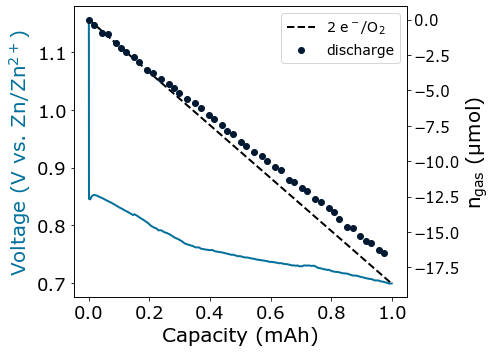

In [4]:
ocv_expt_disch = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211013_Zn-O2-cycle_dems_ocv_postdisch/211013_Zn-O2-cycle_demsafterdischarge_disch_Ch2__2021-10-13_11.58_57.txt')
ocv_expt_disch_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211013_Zn-O2-cycle_dems_ocv_postdisch/')

plot_cycle(ocv_expt_disch_fold[5], ocv_expt_disch_fold[5], ocv_expt_disch, 2, n=2)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211013_Zn-O2-cycle_dems_ocv_postdisch/211013_Zn_O2_discharge_plot.png', transparent = True, dpi=600, bbox_inches='tight')



discharge current (mA): -0.49996684939637825
129.68292826909598
o2 consumed: -0.6470578044674653
o2 evolved: 0.630649567586957
-0.9746417757931033
e per mol on discharge = -115.32009723140906


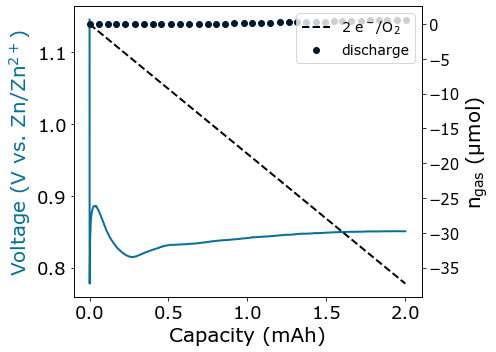

In [11]:
#sem imaging
sem_zn_disch = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211019_Zn_OTf_discharge_SEM_2mAh/211019_Zn_OTf_discharge_SEM_2mAh_Ch4__2021-10-19_17.04_47.txt')
sem_zn_disch_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211019_Zn_OTf_discharge_SEM_2mAh/')

sem_zn_disch_fold[2]['Capacity/mA.h']= sem_zn_disch_fold[2]['Capacity/mA.h'] + sem_zn_disch_fold[1]['Capacity/mA.h'].iloc[-1]
newpd = pd.concat([sem_zn_disch_fold[1], sem_zn_disch_fold[2]])

plot_cycle(newpd, newpd, sem_zn_disch, 4, n=2)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211019_Zn_OTf_discharge_SEM_2mAh/211019_Zn_OTf_discharge_SEM_2mAh.png', transparent = True, dpi=600, bbox_inches='tight')



discharge current (mA): -0.4997705287686567
-2.887977372656804
o2 consumed: 15.18700935032382
o2 evolved: -14.910991546811573
-0.9818254010947612
e per mol on discharge = 2.4557950695767023


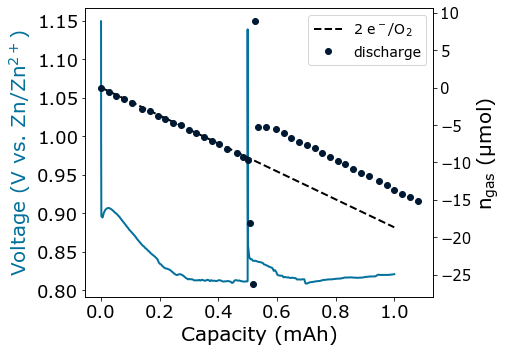

In [13]:
isotopicdemsexpt1_disch_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211019_Zn_halfdisch16O2_halfdisch18O2_dems/211019_Zn_halfdisch16O2_halfdisch18O2_discharge_Ch2__2021-10-19_13.38_02.txt')
isotopicdemsexpt1_disch_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211019_Zn_halfdisch16O2_halfdisch18O2_dems/')

isotopicdemsexpt1_disch_fold[6]['Capacity/mA.h']= isotopicdemsexpt1_disch_fold[6]['Capacity/mA.h'] + isotopicdemsexpt1_disch_fold[4]['Capacity/mA.h'].iloc[-1]
spliced_disch = pd.concat([isotopicdemsexpt1_disch_fold[4], isotopicdemsexpt1_disch_fold[6]])


plot_cycle(spliced_disch, spliced_disch, isotopicdemsexpt1_disch_p, 4, n=2)



discharge current (mA): -0.4997795967041199
-1.7609425457078662
o2 consumed: 24.923657016561165
o2 evolved: -24.75150702230603
-0.9930929079091103
e per mol on discharge = 1.4964475307980647
discharge current (mA): -0.49979869037475344
-3.3819184354388927
o2 consumed: 23.185873957069447
o2 evolved: -22.836244427496865
-0.9849205800816502
e per mol on discharge = 3.217248695536527


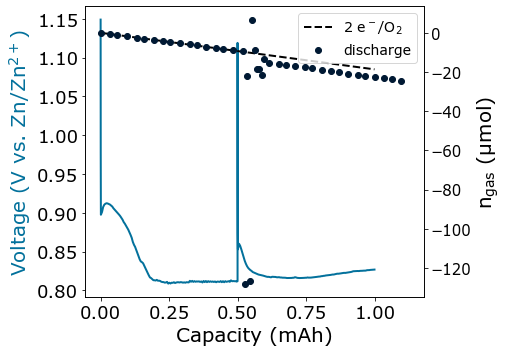

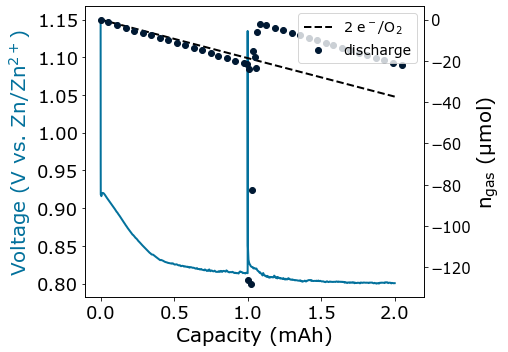

In [22]:
isotopicdemsexpt2_disch_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211025_Zn_switch_halfdisch18O2_dems_chrg/211025_Zn_switch_halfdisch18O2_disch_Ch2__2021-10-25_10.14_20.txt')
isotopicdemsexpt2_disch_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211025_Zn_switch_halfdisch18O2_dems_chrg/')

isotopicdemsexpt2_disch_fold[6]['Capacity/mA.h']= isotopicdemsexpt2_disch_fold[6]['Capacity/mA.h'] + isotopicdemsexpt2_disch_fold[4]['Capacity/mA.h'].iloc[-1]
spliced_disch2 = pd.concat([isotopicdemsexpt2_disch_fold[4], isotopicdemsexpt2_disch_fold[6]])


plot_cycle(spliced_disch2, spliced_disch2, isotopicdemsexpt2_disch_p, 4, n=2)


longdemsdisch_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211101_Zn_halfdisch18O2_2mAh_dems/211101_Zn_halfdisch18O2_2mAh_disch_Ch2__2021-11-01_12.05_22.txt')
longdemsdisch_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211101_Zn_halfdisch18O2_2mAh_dems/')
longdemsdisch_fold[6]['Capacity/mA.h']= longdemsdisch_fold[6]['Capacity/mA.h'] + longdemsdisch_fold[4]['Capacity/mA.h'].iloc[-1]
longdems_spliced_disch = pd.concat([longdemsdisch_fold[4], longdemsdisch_fold[6]])

plot_cycle(longdems_spliced_disch, longdems_spliced_disch, longdemsdisch_p, 4, n=2)


discharge current (mA): -0.5000198675412684
-448.92412121010994
o2 consumed: 0.38306365721872737
o2 evolved: -0.39581062002692136
-1.0332763564696912
e per mol on discharge = 306.53933730364065


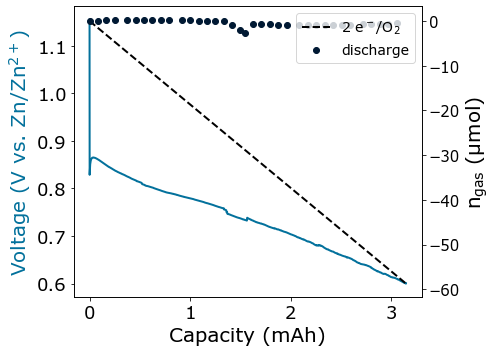

In [21]:
celgard_zn_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211101_Zn_O2_longdisch_500uA_celgard/')
celgard_zn_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211101_Zn_O2_longdisch_500uA_celgard/211101_Zn_O2_longdisch_500uA_celgard_Ch4__2021-11-01_12.46_37.txt')

plot_cycle(celgard_zn_fold[1], celgard_zn_fold[1], celgard_zn_p, 4, n=2)



discharge current (mA): -0.500012131769437
-1.1446699961905968
o2 consumed: 122.05189931825939
o2 evolved: 4.7924947392233435
0.03926603982398142
e per mol on discharge = 0.30571247396546936


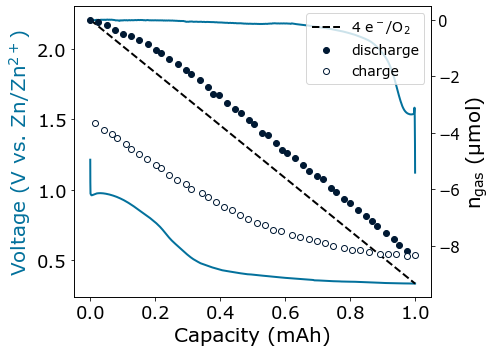

discharge current (mA): -0.49978587562249005
-5.9606067292426825
o2 consumed: 12.10588856712235
o2 evolved: -11.890191025589516
-0.9821824279699193
e per mol on discharge = 3.080860045233578


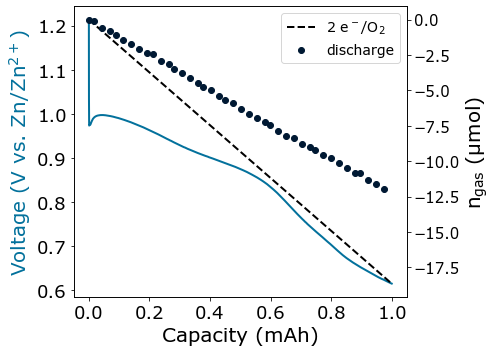

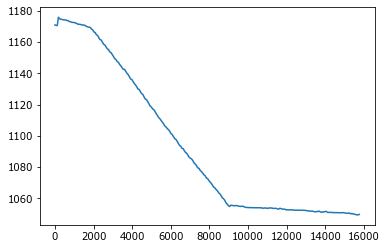

In [10]:
mno2_disch_dems_f = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211123_Zn_O2_MnO2-XC72_cycle_dems/')
mno2_disch_dems_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211123_Zn_O2_MnO2-XC72_cycle_dems/211123_Zn_O2_MnO2-XC72_cycle_disch_Ch2__2021-11-23_18.19_44.txt')
plot_cycle(mno2_disch_dems_f[4], mno2_disch_dems_f[4], mno2_disch_dems_p, 4, n=2)


plt.figure()
plt.plot(mno2_disch_dems_p['time/s'], mno2_disch_dems_p['pressure/torr'])


discharge current (mA): -0.5000050906349207
-9.482662393671474
o2 consumed: 14.741825401217582
o2 evolved: 8.103525270661237
0.5496961909474207
e per mol on discharge = 2.5310836358008655


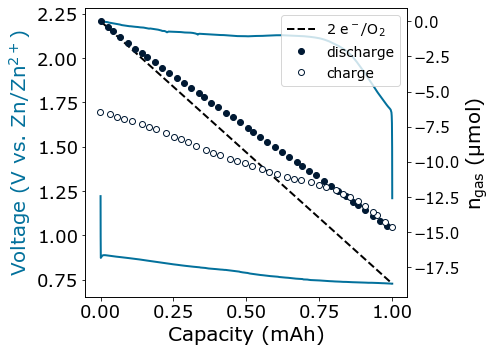

discharge current (mA): -0.49999445492788464
-29.460758534289003
o2 consumed: 1.3111735285689292
o2 evolved: -1.2606963678217085
-0.9615023033584932
e per mol on discharge = 28.45686541113987


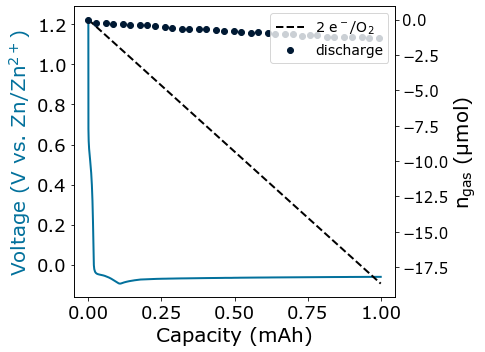

discharge current (mA): -0.4999848425797872
-7.556195988805312
o2 consumed: 12.79634416640127
o2 evolved: 5.5356719848718114
0.43259792897775856
e per mol on discharge = 2.915766741515524


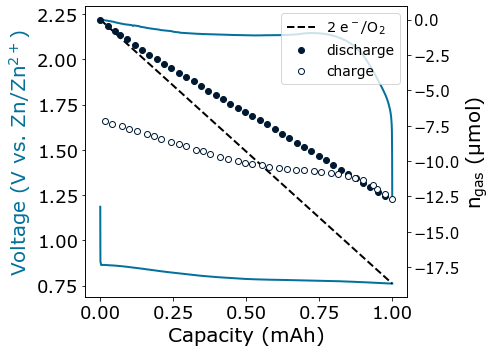